In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.6 MB/s eta 0:00:00


In [3]:
import os
import cv2
import glob
import torch
import shutil
import random
import numpy as np
from tqdm import tqdm
from lxml import etree as ET
import albumentations as A
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

train_dir= "/content/drive/MyDrive/Train/Train"
test_dir= "/content/drive/MyDrive/Test/Test"

temp_dir= "/content/yolo_data"
os.makedirs(f"{temp_dir}/images/train", exist_ok=True)
os.makedirs(f"{temp_dir}/images/valid", exist_ok=True)
os.makedirs(f"{temp_dir}/images/test", exist_ok=True)
os.makedirs(f"{temp_dir}/labels/train", exist_ok=True)
os.makedirs(f"{temp_dir}/labels/valid", exist_ok=True)
os.makedirs(f"{temp_dir}/labels/test", exist_ok=True)

Mounted at /content/drive


In [5]:
image_paths=glob.glob(f"{train_dir}/*.jpg")
random.shuffle(image_paths)

train_files=image_paths[:int(0.85*len(image_paths))]
valid_files=image_paths[int(0.85*len(image_paths)):]

def split_data(files_range,loc,mode):
  for img_path in tqdm(files_range):
    os.makedirs(f"{loc}/temp/{mode}", exist_ok=True)
    img_name=os.path.basename(img_path)
    label_path=img_path.replace('/images','/labels').replace(".jpg",".xml")

    shutil.copy(img_path,f"{loc}/temp/{mode}/{img_name}")
    shutil.copy(label_path,f"{loc}/temp/{mode}/{img_name.replace(".jpg",".xml")}")

In [6]:
list=[0,0,0,0]
for files in train_files:
  if "apple" in files:
    list[0]+=1
  if "banana" in files:
    list[1]+=1
  if "orange" in files:
    list[2]+=1
  if "mixed" in files:
    list[3]+=1
print(list)

[63, 59, 64, 18]


In [7]:
split_data(train_files,f"{temp_dir}","train")
split_data(valid_files,f"{temp_dir}","valid")

100%|██████████| 36/36 [00:00<00:00, 174.41it/s]


Data Annotation

In [8]:
def xml_yolo_format(xml_file,height,width):
  tree= ET.parse(xml_file)
  root= tree.getroot()

  yolo_annotations=[]

  for obj in root.findall("object"):
    name= obj.find("name").text
    id={'apple':0, 'banana':1, 'orange':2}[name]
    xmin= int(obj.find("bndbox/xmin").text)
    xmax= int(obj.find("bndbox/xmax").text)
    ymin= int(obj.find("bndbox/ymin").text)
    ymax= int(obj.find("bndbox/ymax").text)

    x_center=(xmin+xmax)/2/width
    y_center=(ymin+ymax)/2/height
    width_box=(xmax-xmin)/width
    height_box=(ymax-ymin)/height

    yolo_annotations.append(f"{id} {x_center} {y_center} {width_box} {height_box}")
  return yolo_annotations

File Conversion

In [9]:

def xml_to_yolo(xml_file_path, mode):
  xml_paths=glob.glob(os.path.join(xml_file_path,'*.xml'))

  for xml_path in xml_paths:
    img_path=xml_path.replace('xml','jpg')
    txt_path=xml_path.replace('xml','txt')

    img=cv2.imread(img_path)
    x,y,_=img.shape
    yolo_annotations=xml_yolo_format(xml_path,x,y)

    out_img_path=f"{temp_dir}/images/{mode}/{os.path.basename(img_path)}"
    cv2.imwrite(out_img_path,img)

    out_txt_path=f"{temp_dir}/labels/{mode}/{os.path.basename(txt_path)}"
    with open(out_txt_path,'w') as f:
      f.write('\n'.join(yolo_annotations))

In [10]:
xml_to_yolo(f"{temp_dir}/temp/train","train")
xml_to_yolo(f"{temp_dir}/temp/valid","valid")
xml_to_yolo(test_dir,"test")

Data Preprocessing

In [11]:

#Augmentation
transform=A.Compose(
    [
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=15, p=0.5),
    A.ColorJitter(p=0.3)
    ],
    bbox_params=A.BboxParams(format='yolo',label_fields=['class_labels'])
)

#Transformation
img_paths=glob.glob(f"{temp_dir}/images/train/*.jpg")
for img_path in img_paths:
  txt_path=img_path.replace("/images","/labels").replace(".jpg",".txt")

  img=cv2.imread(img_path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  with open (txt_path,"r") as f:
    lines=f.readlines()
    labels=[]
    bbox=[]

    for line in lines:
      c,x,y,w,h=map(float, line.split())
      labels.append(int(c))
      bbox.append([x,y,w,h])

  transformed=transform(image=img, bboxes=bbox, class_labels=labels)
  new_img=transformed['image']
  new_bbox=transformed['bboxes']
  new_labels=transformed['class_labels']

  #Saving
  cv2.imwrite(img_path,cv2.cvtColor(new_img,cv2.COLOR_RGB2BGR))

  with open (txt_path,'w') as f:
    for labels,bboxs in zip(new_labels,new_bbox):
      x,y,w,h=bboxs
      f.write(f"{labels} {x} {y} {w} {h} \n")

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [12]:
#Augmentation For Banana Images
transform=A.Compose(
    [
    A.RandomBrightnessContrast(p=0.4),
    A.ColorJitter(p=0.3),
    A.GaussianBlur(p=0.2),
    A.MotionBlur(p=0.2),
    A.RandomShadow(p=0.2)
    ],
    bbox_params=A.BboxParams(format='yolo',label_fields=['class_labels'])
)

#Seperation of Banana Images
img_paths=glob.glob(f"{temp_dir}/images/train/*.jpg")
list2=[]
for files in img_paths:
  if "banana" in files:
    list2.append(files)

#Transformation
for img_path in list2:
  txt_path=img_path.replace("/images","/labels").replace(".jpg",".txt")

  img=cv2.imread(img_path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  with open (txt_path,"r") as f:
    lines=f.readlines()
    labels=[]
    bbox=[]

    for line in lines:
      c,x,y,w,h=map(float, line.split())
      labels.append(int(c))
      bbox.append([x,y,w,h])

  transformed=transform(image=img, bboxes=bbox, class_labels=labels)
  new_img=transformed['image']
  new_bbox=transformed['bboxes']
  new_labels=transformed['class_labels']

  #Saving
  cv2.imwrite(img_path,cv2.cvtColor(new_img,cv2.COLOR_RGB2BGR))

  with open (txt_path,'w') as f:
    for labels,bboxs in zip(new_labels,new_bbox):
      x,y,w,h=bboxs
      f.write(f"{labels} {x} {y} {w} {h} \n")

/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


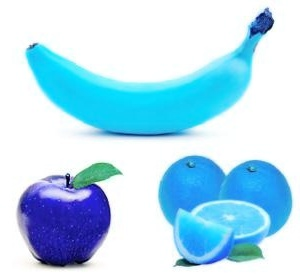

In [13]:
#Sample Image
from google.colab.patches import cv2_imshow
img_pa=glob.glob("/content/yolo_data/images/train/*.jpg")
img_pat=random.choice(img_pa)
img=cv2.imread(img_pat)
cv2_imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

Yaml File Creation

In [14]:
yaml_file="""
train: /content/yolo_data/images/train
val: /content/yolo_data/images/valid
nc: 3
names: ["apple", "banana", "orange"]
"""
with open("/content/yolo_data/data.yaml","w") as f:
  f.write(yaml_file)

Model Training

In [15]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
model=YOLO("yolov8s.pt")
model.train(
    data="/content/yolo_data/data.yaml",
    epochs=80,
    batch=8,
    patience=15,
    device=device
)

engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78eb66246150>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

Model Validation

In [17]:
metrics=model.val(data="/content/yolo_data/data.yaml",
                   device=0)
print(metrics)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 945.0±243.2 MB/s, size: 64.1 KB)
val: Scanning /content/yolo_data/labels/valid.cache... 36 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 36/36 10.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.3it/s 2.3s
                   all         36         77      0.931      0.844      0.913      0.649
                 apple         14         30      0.985      0.967      0.988      0.793
                banana         16         29      0.868      0.682      0.796       0.46
                orange         10         18      0.941      0.884      0.956      0.693
Speed: 10.3ms preprocess, 24.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/runs/detect/val
ultralytics.uti

Metrics

In [18]:
print("Precision : ", metrics.box.p)
print("Recall    : ", metrics.box.r)
print("F1        : ", metrics.box.f1)
print("mAP50     : ", metrics.box.map50)
print("mAP50-95  : ", metrics.box.map)
print("Confusion matrix: \n", metrics.confusion_matrix.matrix)

Precision :  [    0.98481     0.86821     0.94084]
Recall    :  [    0.96667     0.68176     0.88374]
F1        :  [    0.97565     0.76377      0.9114]
mAP50     :  0.913398860872526
mAP50-95  :  0.6487951399218364
Confusion matrix: 
 [[         29           0           0           0]
 [          0          23           1           6]
 [          0           0          16           2]
 [          1           6           1           0]]


Model Testing

In [19]:
result=model.predict(source="/content/yolo_data/images/test",
                     save=True,
                    device=device)


image 1/60 /content/yolo_data/images/test/apple_77.jpg: 512x640 4 apples, 80.3ms
image 2/60 /content/yolo_data/images/test/apple_78.jpg: 640x640 1 apple, 27.7ms
image 3/60 /content/yolo_data/images/test/apple_79.jpg: 640x640 1 apple, 15.9ms
image 4/60 /content/yolo_data/images/test/apple_80.jpg: 544x640 1 apple, 75.6ms
image 5/60 /content/yolo_data/images/test/apple_81.jpg: 640x576 1 apple, 84.3ms
image 6/60 /content/yolo_data/images/test/apple_82.jpg: 640x576 1 apple, 15.5ms
image 7/60 /content/yolo_data/images/test/apple_83.jpg: 608x640 1 apple, 74.1ms
image 8/60 /content/yolo_data/images/test/apple_84.jpg: 448x640 4 apples, 71.5ms
image 9/60 /content/yolo_data/images/test/apple_85.jpg: 512x640 1 apple, 14.2ms
image 10/60 /content/yolo_data/images/test/apple_86.jpg: 448x640 4 apples, 13.8ms
image 11/60 /content/yolo_data/images/test/apple_87.jpg: 640x640 1 apple, 21.5ms
image 12/60 /content/yolo_data/images/test/apple_88.jpg: 640x640 1 banana, 15.9ms
image 13/60 /content/yolo_data/i

In [20]:
#Sample Bounding Box Details
for r in result:
  for box in r.boxes:
    print("Class :", int(box.cls[0]))
    print("Conf  :", float(box.conf[0]))
    print("XYXY  :", box.xyxy[0].tolist())
    print("XYWH  :", box.xywh[0].tolist())
    print("-----")
  break

Class : 0
Conf  : 0.9069559574127197
XYXY  : [66.7731704711914, 57.10124969482422, 176.85565185546875, 164.19384765625]
XYWH  : [121.81440734863281, 110.64755249023438, 110.08248138427734, 107.09259796142578]
-----
Class : 0
Conf  : 0.9051592946052551
XYXY  : [209.45310974121094, 146.57838439941406, 299.713134765625, 228.54827880859375]
XYWH  : [254.5831298828125, 187.56332397460938, 90.26002502441406, 81.96989440917969]
-----
Class : 0
Conf  : 0.8531926274299622
XYXY  : [104.43219757080078, 125.71797180175781, 220.15853881835938, 226.648681640625]
XYWH  : [162.2953643798828, 176.18331909179688, 115.7263412475586, 100.93070983886719]
-----
Class : 0
Conf  : 0.7551783323287964
XYXY  : [7.844845771789551, 17.127094268798828, 95.79131317138672, 112.98417663574219]
XYWH  : [51.81808090209961, 65.05563354492188, 87.94646453857422, 95.85708618164062]
-----


Visualization

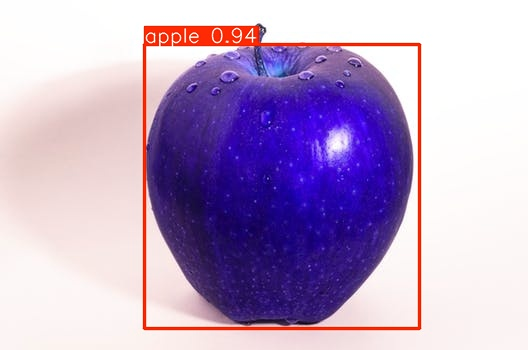

In [25]:
from google.colab.patches import cv2_imshow
img_pa=glob.glob("/content/runs/detect/predict/*.jpg")
img_pat=random.choice(img_pa)
img=cv2.imread(img_pat)
cv2_imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [27]:
!find /content -name "best.pt"

/content/runs/detect/train/weights/best.pt


In [29]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.0
    Uninstalling cachetools-7.0.0:
      Successfully uninstalled cachetools-7.0.0


In [31]:
from google.colab import files
files.download("/content/runs/detect/train/weights/best.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
%%writefile fruitdetection.py
import streamlit as st
from ultralytics import YOLO
from PIL import Image
import numpy as np

st.title("🍎Fruit Object Detection🍏")
st.header("📝Instruction")
st.write("• Upload only JPG, JPEG or PNG images")
st.write("• Click **Detect** For Identifiction")

model=YOLO("/content/drive/MyDrive/best.pt")

images=st.file_uploader("Upload your Image",accept_multiple_files=True,type=["jpg","jpeg","png"])

button= st.button("Detect")

if button:
    for image in images:
        image=Image.open(image)
        image=np.array(image)
        pred=model(image)
        img=pred[0].plot()
        st.image(img)

Writing fruitdetection.py


In [35]:
!streamlit run fruitdetection.py & npx cloudflared tunnel --url http://localhost:8501

⠙

⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴Need to install the following packages:
cloudflared@0.7.1
Ok to proceed? (y) 
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.198.236.73:8501

y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹2026-02-14T08:31:51Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-02-14T08:31:51Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-02-14T08:31:5